# goes-make-ortho-map

This notebook walks through creating a map that relates grid cells from a DEM to the GOES ABI pixels that contain those grid cells, which can then be used to orthorectify GOES ABI products.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio

import warnings
warnings.filterwarnings('ignore')

In [2]:
def ABIangle2LonLat(x, y, H, req, rpol, lon_0_deg):
    '''This function finds the latitude and longitude (degrees) of point P 
    given x and y, the ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    # solve for rc on the ellipsoid
    #_rc = c*cos(A) ± √[ a2 - c2 sin2 (A) ]
    # add elevation z to rc
    # compute new rs value
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0_deg - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lon,lat)


In [3]:
def LonLat2ABIangle(lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg):
    '''This function finds the ABI elevation (y) and scanning (x) angles (radians) of point P, 
    given a latitude and longitude (degrees)'''
    
    # convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)
      
    # geocentric latitude
    lat_geo = np.arctan( (rpol**2 / req**2) * np.tan(lat) )

    # geocentric distance to point on the ellipsoid
    _rc = rpol / np.sqrt(1 - (e**2)*(np.cos(lat_geo)**2)) # this is rc if point is on the ellipsoid
    rc = _rc + z # this is rc if the point is offset from the ellipsoid by z (meters)

    # intermediate calculations
    Sx = H - rc * np.cos(lat_geo) * np.cos(lon - lon_0)
    Sy = -rc * np.cos(lat_geo) * np.sin(lon - lon_0)
    Sz = rc * np.sin(lat_geo)
    
    # calculate x and y scan angles
    y = np.arctan( Sz / Sx )
    x = np.arcsin( -Sy / np.sqrt( Sx**2 + Sy**2 + Sz**2 ) )
    
    ## determine if this point is visible to the satellite
    #condition = ( H * (H-Sx) ) < ( Sy**2 + (req**2 / rpol**2)*Sz**2 )
    #if condition == True:
    #    print('Point at {},{} not visible to satellite.'.format(lon_deg,lat_deg))
    #    return (np.nan, np.nan)
    #else:
    #    return (x,y)
    return (x,y)
    

In [4]:
def ABIpixelMap(abi_grid_x, abi_grid_y, ifov):
    '''Converts an array of continuous ABI scan angles into discrete pixel center locations 
    (still in scan angle coordinates, but incrimenting by the pixel IFOV)'''
    # Convert from scan angle to pixel row/column coordinates 
    x_px = abi_grid_x / (ifov)
    y_px = abi_grid_y / (ifov)

    # Get the center coordinate of the pixel each grid cell lies within
    #center_x = (np.floor(x_px)+0.5)*(ifov)
    #center_y = (np.floor(y_px)+0.5)*(ifov)
    
    # Get the pixel coordinate (row/column) that each grid cell lies within
    center_x = (np.floor(x_px))
    center_y = (np.floor(y_px))
    
    return center_x, center_y

In [5]:
# Values needed for geometry calculations
req = 6378137 #g16_b02.goes_imager_projection.semi_major_axis
rpol = 6356752.31414 #g16_b02.goes_imager_projection.semi_minor_axis
H = 42164160 #g16_b02.goes_imager_projection.perspective_point_height + g16_b02.goes_imager_projection.semi_major_axis
lon_0 = -137.2 #g16_b02.goes_imager_projection.longitude_of_projection_origin
e = 0.0818191910435 # GRS-80 eccentricity

#### Load a DEM:

In [267]:
dem = xr.open_rasterio('dem.tif') #or grandmesa_dem.tif
dem = dem.where(dem!=dem.nodatavals[0])[0,:,:] # replace nodata with nans
dem = dem.where(dem!=0) # replace zeros with nans

In [268]:
dem

<xarray.DataArray (y: 1501, x: 1995)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band     int32 1
  * y        (y) float64 38.2 38.2 38.19 38.19 38.19 ... 37.73 37.73 37.73 37.73
  * x        (x) float64 -119.8 -119.8 -119.8 -119.8 ... -119.2 -119.2 -119.2
Attributes:
    transform:   (0.0003115924696741881, 0.0, -119.806908765, 0.0, -0.0003115...
    crs:         +init=epsg:4326
    res:         (0.0003115924696741881, 0.0003115924696868757)
    is_tiled:    0
    nodatavals:  (-9999.0,)

##### Demo this:
For a single point on the DEM, determine which ABI pixel it is contained within, taking into account terrain parallax


Starting point lon, lat, z: -119.31212 37.88175 2811
Scan angle x, y: -0.09035872257477835 0.10075904750779954
Erroneous lon, lat: -119.36570903570059 37.90851741595954
Offset (km) (E-W, N-S): -5.948382962766246 2.9711831715089545
Pixel coords relative to origin (x,y): -1614.0 1800.0
The center of this pixel is at (x,y): -0.09035599999999999 0.100772

Starting point lon, lat, z: -119.31212 37.88175 2811
Scan angle x, y: 0.041206043100924364 0.10391420176004901
Erroneous lon, lat: -119.29575228202233 37.906318006573315
Offset (km) (E-W, N-S): 1.8168166955200888 2.7270487296383266
Pixel coords relative to origin (x,y): 735.0 1856.0
The center of this pixel is at (x,y): 0.041188 0.103908


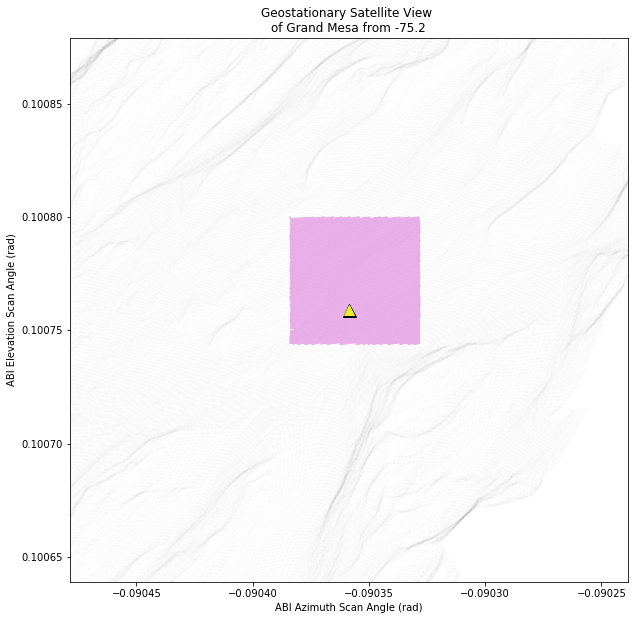

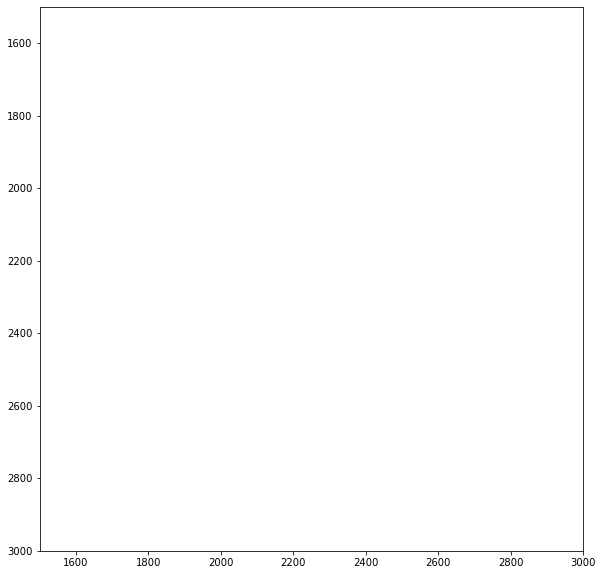

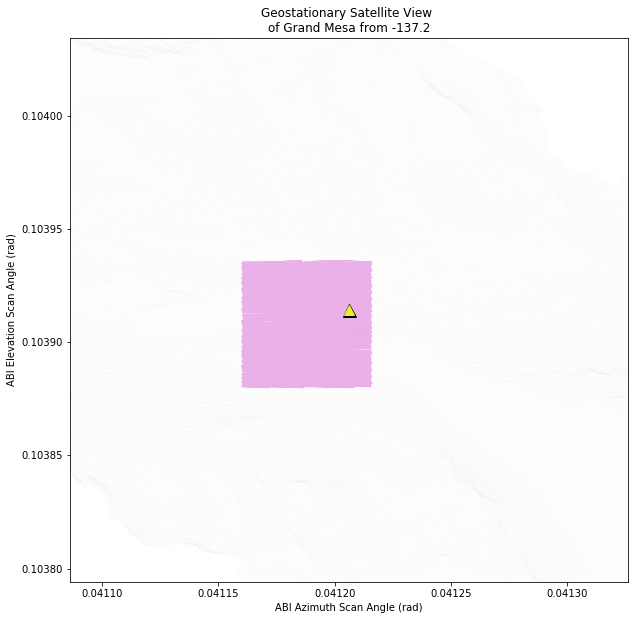

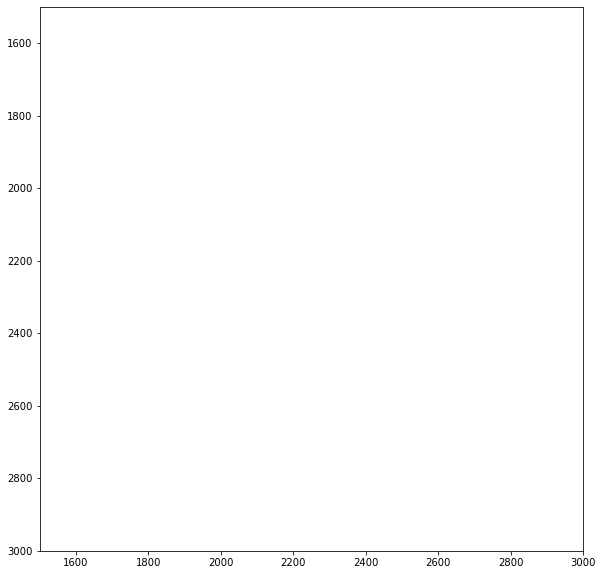

In [91]:
for lon_0 in [-75.2, -137.2]: #-137.2, -80, -90, -100, -110, -120, -130, 
    sat = 'Geostationary Orbit at {} Longitude'.format(lon_0)
    if lon_0 == -75.2:
        sat = 'GOES-East'
    if lon_0 == -137.2:
        sat = 'GOES-West'
        
    
    #lat = 39.0339
    #lon = -108.2140
    #z = 3033
    lat = 37.88175
    lon = -119.31212
    z = 2811
    print('\nStarting point lon, lat, z:',lon, lat, z)

    # find corresponding angles
    x, y = LonLat2ABIangle(lon,lat,z,H,req,rpol,e,lon_0)
    print('Scan angle x, y:',x, y)

    # use these to go back to our original lon and lat without taking elevation into account
    _lon, _lat = ABIangle2LonLat(x,y,H,req,rpol,lon_0)
    print('Erroneous lon, lat:',_lon, _lat)

    print('Offset (km) (E-W, N-S):',(_lon-lon)*111, (_lat-lat)*111)
    
    # Convert from scan angle to pixel coordinates for the 56 urad ("2km") pixels 
    ifov = 56e-6
    x_px = x / (ifov)
    y_px = y / (ifov)
    print('Pixel coords relative to origin (x,y):',np.floor(x_px),np.ceil(y_px))

    ## Get the center of the pixel we're in (back in scan angle coordinates)
    center_x = (np.floor(x_px)+0.5)*(ifov)
    center_y = (np.floor(y_px)+0.5)*(ifov)
    print('The center of this pixel is at (x,y):',center_x,center_y)

    # for each grid cell in the DEM, compute the corresponding ABI scan anlge (x and y, radians)
    X, Y = np.meshgrid(dem.x,dem.y) # Lon and Lat of each DEM grid cell
    Z = dem.values # elevation of each DEM grid cell
    abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)

    # Find the ABI pixel that our point is contained within
    x_cond = (abi_grid_x >= (center_x-(0.5*ifov))) & (abi_grid_x <= (center_x+(0.5*ifov)))
    y_cond = (abi_grid_y >= (center_y-(0.5*ifov))) & (abi_grid_y <= (center_y+(0.5*ifov)))
    # This makes a map of True and False values
    pixel_of_interest = (x_cond & y_cond)
    # Now make a map of 1s and Nans to represent where our pixel is
    pixel_map = np.zeros(pixel_of_interest.shape)
    pixel_map[pixel_of_interest==True] = 1
    pixel_map[pixel_of_interest==False] = np.nan
    
  
    # Plot a hillshade of the DEM as seen from geostationary orbit at lon_0
    plt.figure(figsize=(10,10))
    plt.plot(abi_grid_x,abi_grid_y,'.',c='grey',markersize=1,alpha=0.02)
    plt.plot(abi_grid_x[pixel_of_interest],abi_grid_y[pixel_of_interest], alpha=0.3, c='m') # make sure we're looking at the right pixel
    plt.plot(x,y,'^',c='k',markersize=13) # location of gaylor pit
    plt.plot(x,y,'^',c='#eaec2c',markersize=10) # location of gaylor pit
    #plt.plot([center_x-28e-6, center_x+28e-6,center_x+28e-6, center_x-28e-6, center_x-28e-6],
    #         [center_y+28e-6, center_y+28e-6,center_y-28e-6, center_y-28e-6, center_y+28e-6],':r') # the pixel we're in
    plt.xlim((x-0.00012,x+0.00012))
    plt.ylim((y-0.00012,y+0.00012))
    plt.title('Geostationary Satellite View \nof Grand Mesa from {}'.format(lon_0))
    plt.xlabel('ABI Azimuth Scan Angle (rad)')
    plt.ylabel('ABI Elevation Scan Angle (rad)')
    #plt.savefig('grandmesa_GOES-R_ABI_parallax_30m_{}_GrandMesa.png'.format(str(lon_0)),dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Plot the pixel we're in overlayed on the DEM
    plt.figure(figsize=(10,10))
    plt.imshow(Z,cmap='terrain')
    plt.imshow(pixel_map,alpha=0.3,cmap='spring')
    plt.xlim((1500,3000))
    plt.ylim((3000,1500))
    #plt.savefig('grandmesa_GOES-R_ABI_parallax_30m_{}_GrandMesa_overlay.png'.format(str(lon_0)),dpi=300,bbox_inches='tight')


For the entire DEM, determine what ABI pixel every DEM grid cell belongs to, taking into account terrain parallax

In [278]:
# map every DEM grid cell to a corresponding ABI pixel (using center of pixel scan angle x and y)
lon_0 = -75.2 #-137.2 #

# IFOV for the 56 urad ("2km") infrared pixels
ifov = 56e-6

# for each grid cell in the DEM, compute the corresponding ABI scan anlge (x and y, radians)
X, Y = np.meshgrid(dem.x,dem.y) # Lon and Lat of each DEM grid cell
Z = dem.values # elevation of each DEM grid cell

# with parallax
abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)
center_x, center_y = ABIpixelMap(abi_grid_x, abi_grid_y, ifov)

# without parallax
_abi_grid_x, _abi_grid_y = LonLat2ABIangle(X,Y,np.zeros_like(Z),H,req,rpol,e,lon_0)
_center_x, _center_y = ABIpixelMap(_abi_grid_x, _abi_grid_y, ifov)

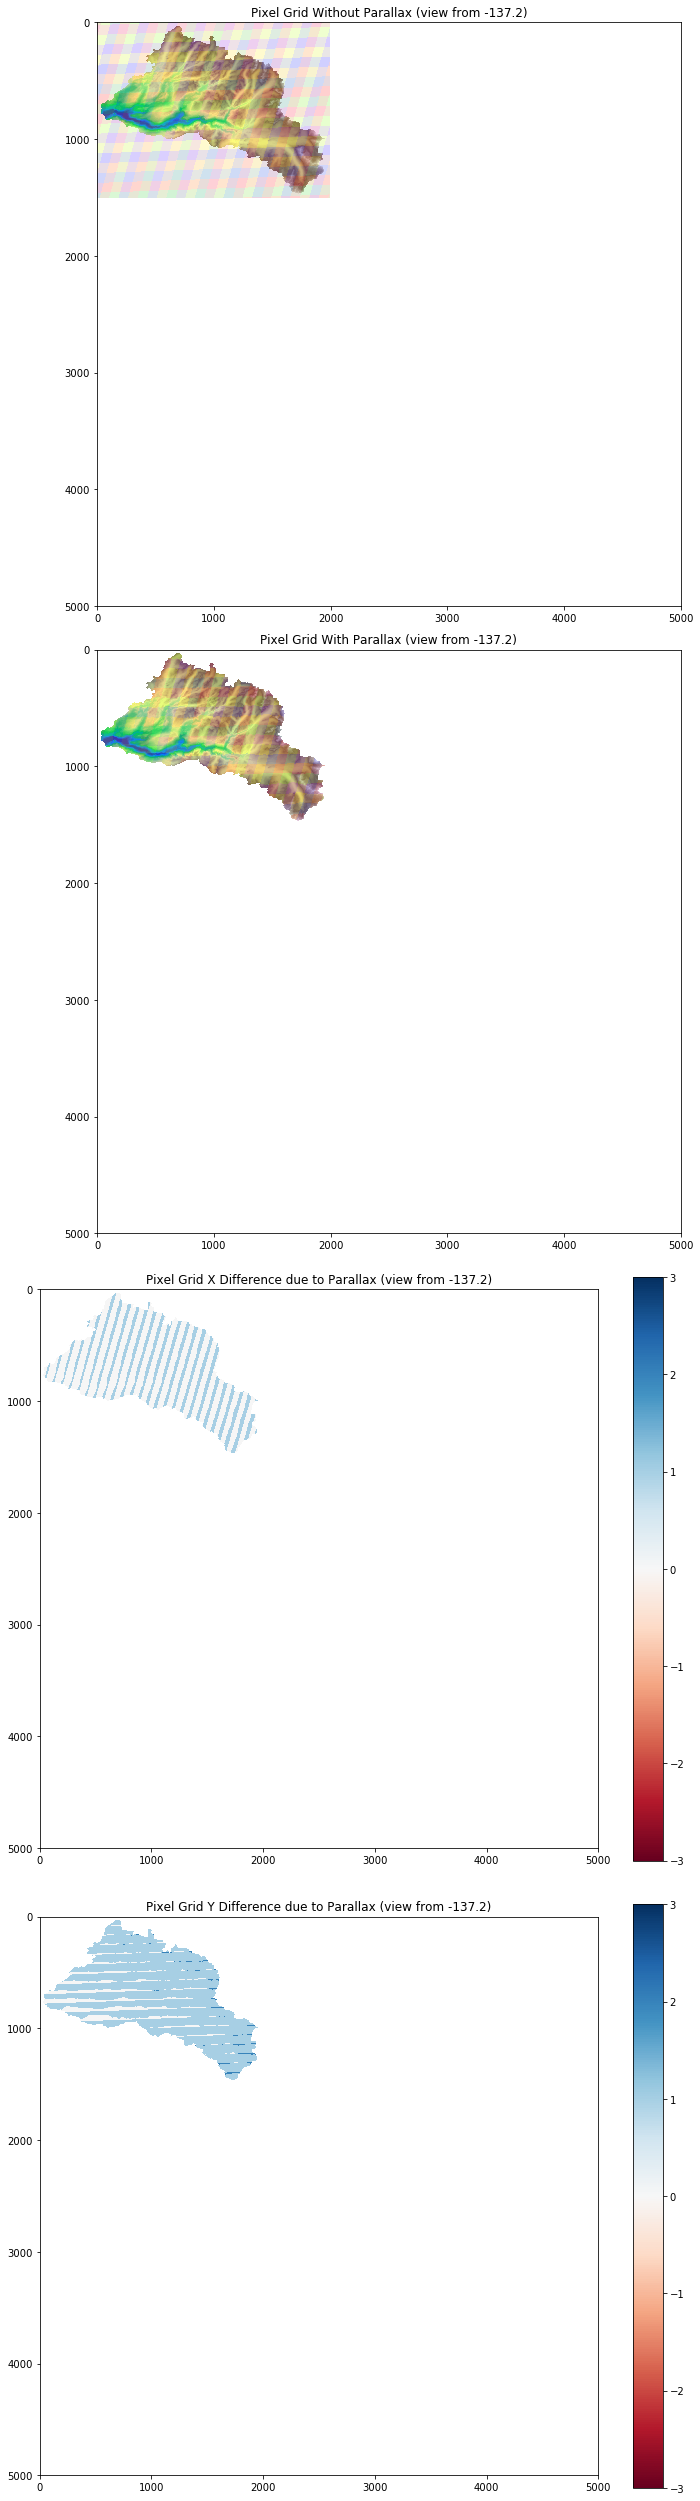

In [274]:
# Plot the original pixel locations over the DEM
fig, ax = plt.subplots(4, 1, figsize=(10,35))
ax[0].set_title('Pixel Grid Without Parallax (view from {})'.format(lon_0))
ax[0].imshow(Z,cmap='terrain')
ax[0].imshow(_center_x,cmap='prism',alpha=0.1)
ax[0].imshow(_center_y,cmap='prism',alpha=0.1)
ax[0].set_xlim((0,5000))
ax[0].set_ylim((5000,0))

# Plot the pixels draped over the DEM
ax[1].set_title('Pixel Grid With Parallax (view from {})'.format(lon_0))
ax[1].imshow(Z,cmap='terrain')
ax[1].imshow(center_x,cmap='prism',alpha=0.1)
ax[1].imshow(center_y,cmap='prism',alpha=0.1)
ax[1].set_xlim((0,5000))
ax[1].set_ylim((5000,0))

# Plot the difference
ax[2].set_title('Pixel Grid X Difference due to Parallax (view from {})'.format(lon_0))
diff_x = ax[2].imshow(center_x - _center_x,vmin=-3, vmax=3,cmap='RdBu')
ax[2].set_xlim((0,5000))
ax[2].set_ylim((5000,0))
fig.colorbar(diff_x, ax=ax[2])

ax[3].set_title('Pixel Grid Y Difference due to Parallax (view from {})'.format(lon_0))
diff_y = ax[3].imshow(center_y - _center_y,vmin=-3, vmax=3,cmap='RdBu')
ax[3].set_xlim((0,5000))
ax[3].set_ylim((5000,0))
fig.colorbar(diff_y, ax=ax[3])

plt.tight_layout()
#plt.savefig('GrandMesa_ABIpixelMapping_{}.jpg'.format(lon_0))

Try to plot only 30 m DEM grid cells that overlap (meaning that they're obscured form view)

In [279]:
# what is the angular size of one of these DEM grid cells?
# if ifov is for 2000 m, then the "ifov" for 30 m is = 30/2000

ifov_dem = (3/200) * ifov

ifov_dem # in radians

8.4e-07

To find where the ground surface is occluded by other terrain (so that we can mask it out), we can look for DEM grid cells that have ABI fixed grid coordinates closer together than the angular size of a DEM grid cell (an imagined IFOV for the DEM grid cell size). If their ABI fixed grid coordinates are closer than the angular size of a DEM grid cell, then they are overlapping. If their ABI fixed grid coordinate are closer than 1/2 the angular size of a DEM grid cell, then they are overlapping by at least 50%.

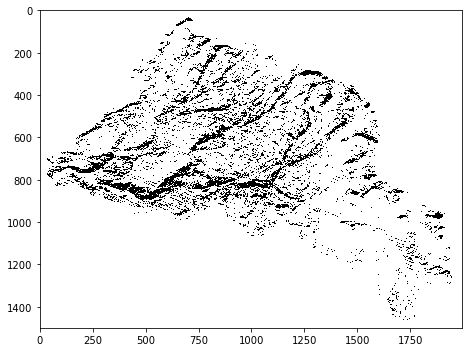

In [280]:
x0 = np.diff(abi_grid_x,axis=0)/ifov_dem # how many dem grid cells apart in the x direction?
x1 = np.diff(abi_grid_x,axis=1)/ifov_dem
y0 = np.diff(abi_grid_y,axis=0)/ifov_dem # how many dem grid cells apart in the y direction?
y1 = np.diff(abi_grid_y,axis=1)/ifov_dem



_x0 = np.where((x0<=-1) | (x0>=1), 0, 1) # creating a mask for x
_x1 = np.where((x1<=-1) | (x1>=1), 0, 1)
_y0 = np.where((y0<=-1) | (y0>=1), 0, 1) # creating a mask for y, where grid cells are overlapping
_y1 = np.where((y1<=-1) | (y1>=1), 0, 1)

# combine all masks by multiplying
terrain_occlusion_mask = _x0[:,:-1] * _y0[:,:-1] * _x1[:-1,:] * _y1[:-1,:]

plt.figure(figsize=(10,5))
plt.imshow(terrain_occlusion_mask,cmap='Greys_r')
plt.tight_layout()
plt.savefig('Tuolumne_TerrainOcclusionMask_{}.jpg'.format(lon_0), dpi=200)

ValueError: operands could not be broadcast together with shapes (1501,1994) (1500,1995) 

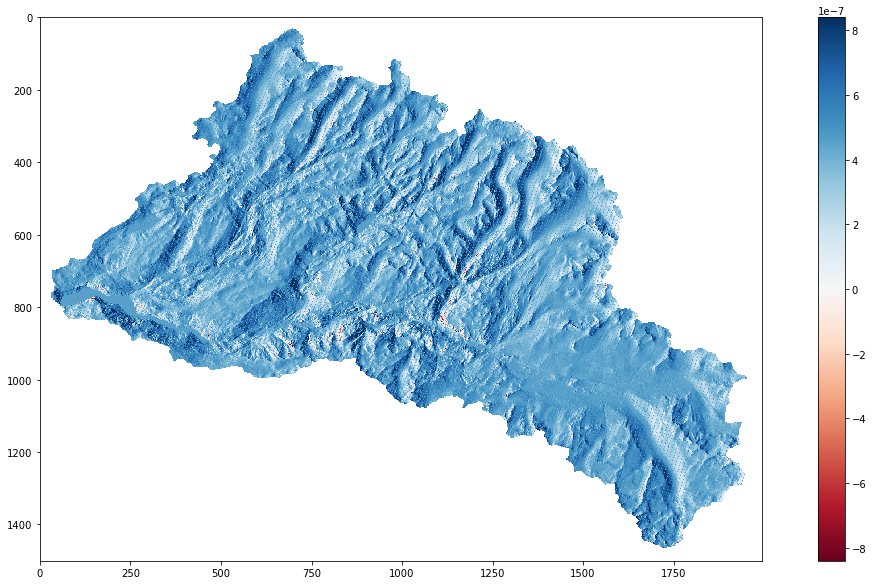

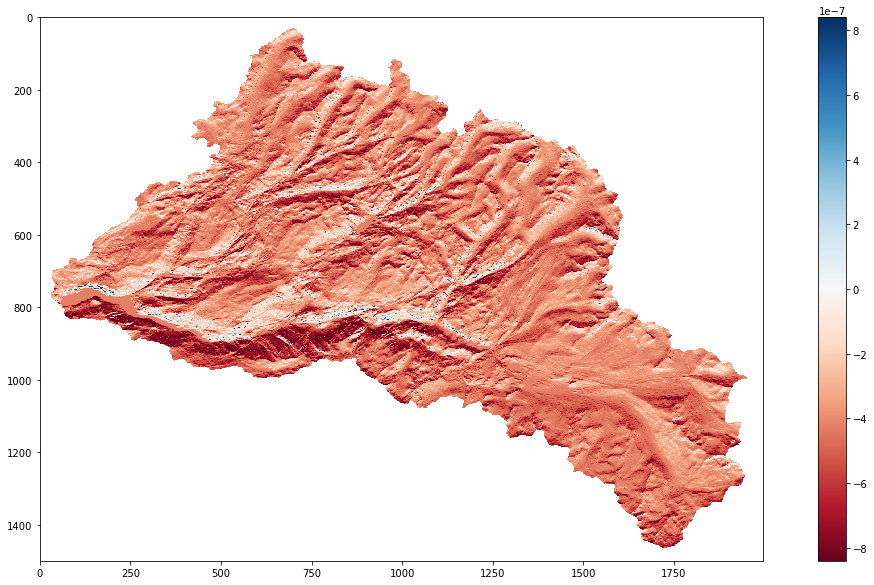

<Figure size 1440x720 with 0 Axes>

In [114]:
# plot the spacing between each DEM grid cell that's been projected into ABI fixed grid space

plt.figure(figsize=(20,10))
plt.imshow(np.diff(abi_grid_x,axis=-1), vmin=-ifov_dem, vmax=ifov_dem, cmap='RdBu')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(np.diff(abi_grid_x,axis=0), vmin=-ifov_dem, vmax=ifov_dem, cmap='RdBu')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(np.diff(abi_grid_y,axis=-1), vmin=-ifov_dem, vmax=ifov_dem, cmap='RdBu')
plt.colorbar()


plt.figure(figsize=(20,10))
plt.imshow(np.diff(abi_grid_y,axis=0), vmin=-ifov_dem, vmax=ifov_dem, cmap='RdBu')
plt.colorbar()

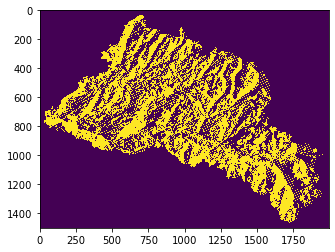

In [109]:
# plot those that exeed the "ifov30m" (any overlapping)


plt.imshow(np.diff(abi_grid_y,axis=-1)<=0)


#### Load a 30m DEM of Tuolumne

In [ ]:
dem = xr.open_rasterio('dem.tif')
dem = dem.where(dem!=dem.nodatavals[0])[0,:,:] # replace nodata with nans


In [ ]:
for lon_0 in [-75.2, -137.2]: #-80, -90, -100, -110, -120, -130,
    sat = 'Geostationary Orbit at {} Longitude'.format(lon_0)
    if lon_0 == -75.2:
        sat = 'GOES-East'
    if lon_0 == -137.2:
        sat = 'GOES-West'
        
    
    lat = 37.88175
    lon = -119.31212
    z = 2811
    print('Starting point lon, lat, z:',lon, lat, z)

    # find corresponding angles
    x, y = LonLat2ABIangle(lon,lat,z,H,req,rpol,e,lon_0)
    print('Scan angle x, y:',x, y)

    # use these to go back to our original lon and lat without taking elevation into account
    _lon, _lat = ABIangle2LonLat(x,y,H,req,rpol,lon_0)
    print('Erroneous lon, lat:',_lon, _lat)

    print('Offset (km) (E-W, N-S):',(_lon-lon)*111, (_lat-lat)*111)
    
    
    x_px = x / (56e-6)
    y_px = y / (56e-6)


    print('Pixel coords relative to origin (x,y):',np.floor(x_px),np.ceil(y_px))


    center_x = (np.floor(x_px)-0.5)*(56e-6)
    center_y = (np.ceil(y_px)+0.5)*(56e-6)
    print('\nThe center of this pixel is at (x,y):',center_x,center_y)
    
    X, Y = np.meshgrid(dem.x,dem.y)
    Z = dem.values
    abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)


    plt.figure()
    plt.plot(abi_grid_x,abi_grid_y,'.',c='k',alpha=0.003)
    plt.plot(x,y,'^',c='k',markersize=23) # location of gaylor pit
    plt.plot(x,y,'^',c='#eaec2c',markersize=20) # location of gaylor pit
    #plt.plot([center_x-28e-6, center_x+28e-6,center_x+28e-6, center_x-28e-6, center_x-28e-6],
    #         [center_y+28e-6, center_y+28e-6,center_y-28e-6, center_y-28e-6, center_y+28e-6],':r') # the pixel we're in
    plt.xlim((x-0.0004,x+0.0004))
    plt.ylim((y-0.0004,y+0.0004))
    #plt.title('View of the Tuolumne River Basin from {}'.format(sat))
    plt.title('Geostationary Satellite View \nof the Tuolumne River Basin from {}'.format(lon_0))
    plt.xlabel('ABI Azimuth Scan Angle (rad)')
    plt.ylabel('ABI Elevation Scan Angle (rad)')
    #plt.savefig('tuolumne_GOES-R_ABI_parallax_30m_{}_GaylorPit_zoom.png'.format(str(lon_0)),dpi=300,bbox_inches='tight')
    #plt.close()
    
    x_cond = (abi_grid_x >= (center_x-(0.5*56e-6))) & (abi_grid_x <= (center_x+(0.5*56e-6)))
    y_cond = (abi_grid_y >= (center_y-(0.5*56e-6))) & (abi_grid_y <= (center_y+(0.5*56e-6)))
    pixel_of_interest = (x_cond & y_cond)
    
    plt.figure()
    plt.imshow(dem)
    plt.imshow(pixel_of_interest,alpha=0.5)

In [ ]:
x_cond = (abi_grid_x >= (center_x-(0.5*56e-6))) & (abi_grid_x <= (center_x+(0.5*56e-6)))
y_cond = (abi_grid_y >= (center_y-(0.5*56e-6))) & (abi_grid_y <= (center_y+(0.5*56e-6)))
pixel_of_interest = (x_cond & y_cond)

plt.figure(figsize=(15,10))
plt.imshow(dem)
plt.imshow(pixel_of_interest,alpha=0.5)


In [ ]:
abi_grid_shape_x = np.

In [ ]:
dem.res

In [ ]:
# Open and write to this new file
with rio.open('goes-pixel-footprint_30m_goeseast.tif', 
              'w', 
              driver='GTiff',
              height=pixel_of_interest.shape[0],
              width=pixel_of_interest.shape[1],
              count=1, 
              dtype='int32',
              nodata=-9999,
              crs=dem.crs, 
              transform=dem.transform) as dst:

    dst.write(pixel_of_interest.astype(int), 1)

In [ ]:
lon_0